In [86]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# loading up the CSV files into dataframes
leases_df = pd.read_csv("Leases.csv")
price_availability_df = pd.read_csv("Price and Availability Data.csv")
occupancy_df = pd.read_csv("Major Market Occupancy Data.csv")
unemployment_df = pd.read_csv("Unemployment.csv")

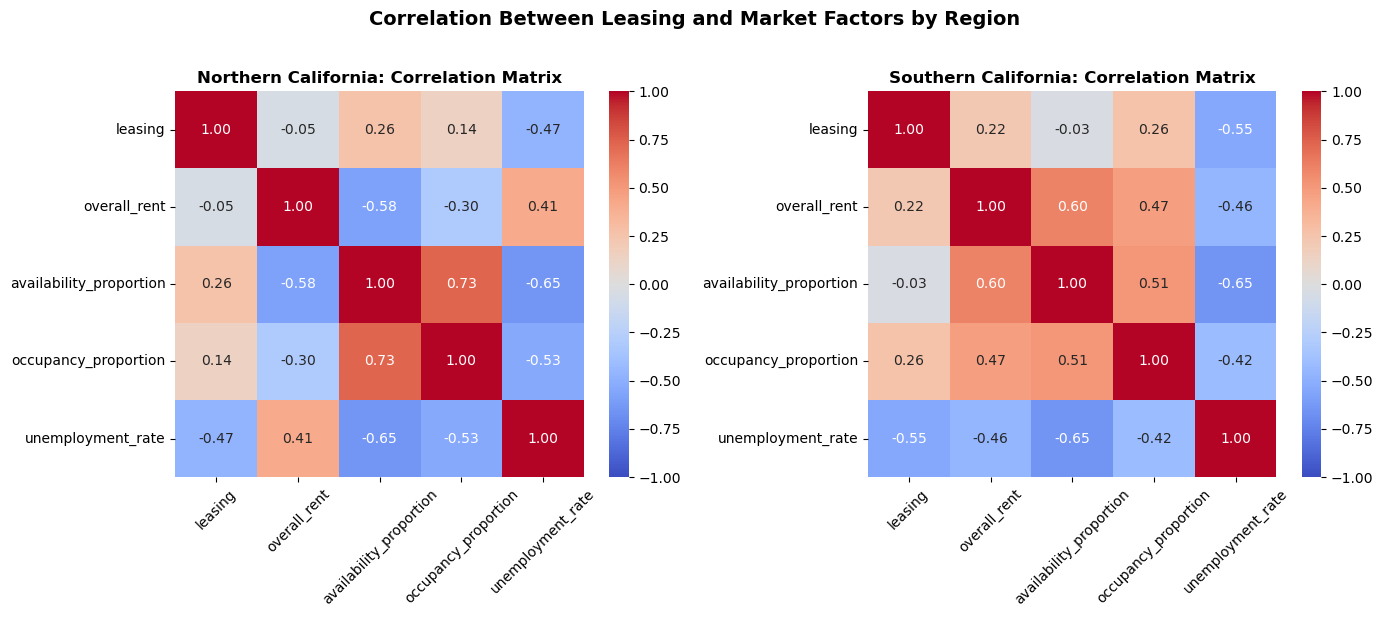

In [106]:
# Standardizing columns to lowercase
leases_df.columns = leases_df.columns.str.lower()
price_availability_df.columns = price_availability_df.columns.str.lower()
occupancy_df.columns = occupancy_df.columns.str.lower()
unemployment_df.columns = unemployment_df.columns.str.lower()

if 'available_sq_ft' in price_availability_df.columns and 'rba' in price_availability_df.columns:
    price_availability_df['availability_proportion'] = price_availability_df['available_sq_ft'] / price_availability_df['rba']

# Creating 'year_quarter' for merging across datasets
for df in [leases_df, price_availability_df, occupancy_df, unemployment_df]:
    df['year_quarter'] = df['year'].astype(str) + "_" + df['quarter'].astype(str)

# Define city/region keywords
norcal = ['San Francisco', 'San Jose', 'South Bay']
socal = ['Los Angeles', 'San Diego', 'Orange County (CA)']

# Assign region to each dataframe
leases_df['region'] = leases_df['city'].apply(
    lambda x: 'NorCal' if x in norcal else 'SoCal' if x in socal else 'Other')

price_availability_df['region'] = price_availability_df['market'].apply(
    lambda x: 'NorCal' if x in norcal else 'SoCal' if x in socal else 'Other')

occupancy_df['region'] = occupancy_df['market'].apply(
    lambda x: 'NorCal' if any(city in x for city in norcal) else 'SoCal' if any(city in x for city in socal) else 'Other')

# unemployment data is state-level, copied it for both regions
unemployment_df_norcal = unemployment_df.copy()
unemployment_df_norcal['region'] = 'NorCal'

unemployment_df_socal = unemployment_df.copy()
unemployment_df_socal['region'] = 'SoCal'

unemployment_df = pd.concat([unemployment_df_norcal, unemployment_df_socal], ignore_index = True)

# Aggregating leasing data (10,000+ sq ft)
leases_filtered = leases_df[leases_df['leasing'] >= 10000][['year_quarter', 'region', 'leasing']]
leases_grouped = leases_filtered.groupby(['year_quarter', 'region'])['leasing'].sum().reset_index()

# Aggregating other datasets by region and year_quarter
price_grouped = price_availability_df[['year_quarter', 'region', 'overall_rent', 'availability_proportion']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

occupancy_grouped = occupancy_df[['year_quarter', 'region', 'occupancy_proportion']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

unemployment_grouped = unemployment_df[['year_quarter', 'region', 'unemployment_rate']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

# Merging all grouped datasets
merged_df = leases_grouped \
    .merge(price_grouped, on = ['year_quarter', 'region'], how = 'left') \
    .merge(occupancy_grouped, on = ['year_quarter', 'region'], how = 'left') \
    .merge(unemployment_grouped, on = ['year_quarter', 'region'], how = 'left')

# Filter only NorCal and SoCal
merged_df = merged_df[merged_df['region'].isin(['NorCal', 'SoCal'])]

# Filter for NorCal and SoCal separately
norcal_df = merged_df[merged_df['region'] == 'NorCal']
socal_df = merged_df[merged_df['region'] == 'SoCal']

# Drop the NaNs and compute correlation matrices
norcal_data = norcal_df[['leasing', 'overall_rent', 'availability_proportion', 'occupancy_proportion', 'unemployment_rate']].dropna()
socal_data = socal_df[['leasing', 'overall_rent', 'availability_proportion', 'occupancy_proportion', 'unemployment_rate']].dropna()

# Calculate correlation matrices
norcal_corr = norcal_data.corr()
socal_corr = socal_data.corr()

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Northern Cali heatmap
sns.heatmap(norcal_corr, annot = True, cmap = 'coolwarm', fmt = ".2f", ax = axes[0], 
            vmin=-1, vmax=1)
axes[0].set_title("Northern California: Correlation Matrix", weight = 'bold')
axes[0].tick_params(axis = 'x', rotation = 45)
axes[0].tick_params(axis = 'y', rotation = 0)

# Southern Cali heatmap
sns.heatmap(socal_corr, annot = True, cmap = 'coolwarm', fmt = ".2f", ax = axes[1], 
           vmin=-1, vmax=1)
axes[1].set_title("Southern California: Correlation Matrix", weight = 'bold')
axes[1].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'y', rotation = 0)

fig.suptitle("Correlation Between Leasing and Market Factors by Region", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


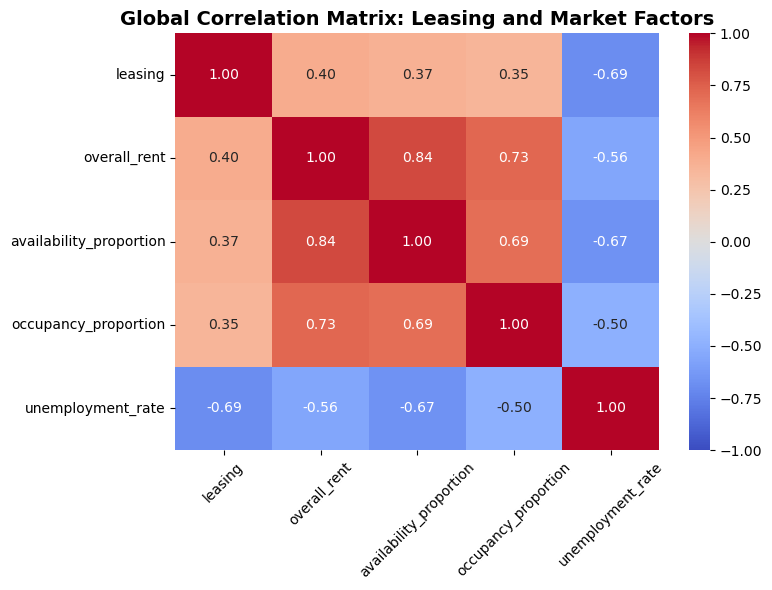

In [100]:
# Standardize column names to lowercase
leases_df.columns = leases_df.columns.str.lower()
price_availability_df.columns = price_availability_df.columns.str.lower()
occupancy_df.columns = occupancy_df.columns.str.lower()
unemployment_df.columns = unemployment_df.columns.str.lower()

if 'available_sq_ft' in price_availability_df.columns and 'rba' in price_availability_df.columns:
    price_availability_df['availability_proportion'] = price_availability_df['available_sq_ft'] / price_availability_df['rba']

# Create 'year_quarter' for consistency (optional but often used for merging)
for df in [leases_df, price_availability_df, occupancy_df, unemployment_df]:
    df['year_quarter'] = df['year'].astype(str) + "_" + df['quarter'].astype(str)

# Filter leases to only ≥10,000 sq ft
leases_filtered = leases_df[leases_df['leasing'] >= 10000][['year_quarter', 'leasing']]
leases_grouped = leases_filtered.groupby('year_quarter')['leasing'].sum().reset_index()

# Group and average the remaining datasets
price_grouped = price_availability_df[['year_quarter', 'overall_rent', 'availability_proportion']] \
    .groupby('year_quarter').mean().reset_index()

occupancy_grouped = occupancy_df[['year_quarter', 'occupancy_proportion']] \
    .groupby('year_quarter').mean().reset_index()

unemployment_grouped = unemployment_df[['year_quarter', 'unemployment_rate']] \
    .groupby('year_quarter').mean().reset_index()

# Merge all into a global dataframe
global_df = leases_grouped \
    .merge(price_grouped, on='year_quarter', how='left') \
    .merge(occupancy_grouped, on='year_quarter', how='left') \
    .merge(unemployment_grouped, on='year_quarter', how='left')

# Drop rows with missing data
global_df_clean = global_df.dropna()

# Compute correlation matrix
global_corr = global_df_clean[['leasing', 'overall_rent', 'availability_proportion',
                               'occupancy_proportion', 'unemployment_rate']].corr()

# Plot the global heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(global_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Global Correlation Matrix: Leasing and Market Factors", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
